In [15]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

In [16]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# local libs
import config, models, setup
import midi
from midi import generators as g
from utils import io, models_io, utils, plot

In [18]:
context = setup.init()

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 10.0 0.5
 >> Context(max_t=2.0, dt=0.05, n_timesteps=40, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  40.000000
 max_f: 10.000000, min_f: 0.500000


In [19]:
n = 100 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, dirname=dn, multiTrack=multiTrack, r=True)


Importing midi-data

Encoding midi-data
 100
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [20]:
# n = 1000
# min_f = 0
# max_f = 3
# x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
#     n_polyrythms=1,
#     n_channels=3,
#     d_phase=True,
#     return_params=True,
#     dim4=dim4,
#     multiTrack=multiTrack)

In [21]:
x_train.shape

(100, 40, 10, 1)

In [120]:
m = int(x_train.shape[0] * 0.9)
[x_train.shape, m]

[(90, 40, 10, 1), 81]

In [121]:
x_test = x_train[m:]
x_train = x_train[:m]

m (40, 10)


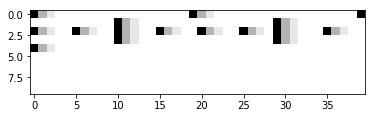

m (40, 10)


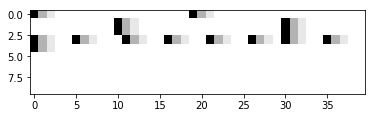

m (40, 10)


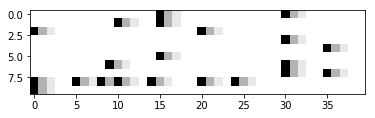

["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid",
 "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"]

In [122]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
plot.single(x_train[2, :50,:,0])
labels[0:4]

In [123]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(40, 10, 1)

In [124]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [162]:
def encoder(input_shape, dropout=0.05):
    encoder_input = Input(shape=input_shape)
    nodes = np.prod(input_shape)

    # Convolution
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='valid')(h)
    h = Conv1D(128, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    
    # RNN
    shape = K.int_shape(h)[1:]
    h = SimpleRNN(128)(h)

    # Dense layers
#     h = Dropout(dropout)(h) # uncomment when using larger batches
#     h = Flatten()(h)
#     h = Dropout(dropout)(h) # uncomment when using larger batches
    
    h = Dense(intermediate_dim*2, activation='relu')(h)
    h = Dense(intermediate_dim, activation='relu')(h)
   
    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [163]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 40, 10, 1)    0                                            
__________________________________________________________________________________________________
reshape_34 (Reshape)            (None, 40, 10)       0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1d_49 (Conv1D)              (None, 39, 32)       672         reshape_34[0][0]                 
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 19, 64)       4160        conv1d_49[0][0]                  
__________________________________________________________________________________________________
conv1d_51 

In [164]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [165]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)
# z_output = Lambda(sampl_, output_shape=(latent_dim,))(encoder_input)

In [166]:
def list_decoders(output_shape, p='same'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape
    time_ = int(timesteps/10)
    notes_ = notes * 10
    intermediate_dim = time_ * notes_ * channels
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (timesteps, notes, channels)
    nodes = np.prod(output_shape)
    
    decoders = []
    decoders += [ Dense(256, activation='relu') ]
    decoders += [ Dense(256, activation='relu') ]
    
    # RNN
    decoders += [ Reshape((8, 32)) ]
    decoders += [ SimpleRNN(128, return_sequences='True') ]
    # TODO 2nd RNN to generate the 'repeating' state (aka decay matrix)
    decoders += [ Flatten() ]
    decoders += [ Dense(nodes, activation='relu') ]
    decoders += [ Dense(nodes, activation='relu') ]


#     # Convolve & Pool
#     # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
#     k = (2,1) # (2,1) :: (timesteps, notes)
#     s = (3,1)

#     decoders += [ Reshape((time_, notes_, channels)) ]
#     decoders += [ Conv2DTranspose(128, kernel_size=2, strides=3, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(64, kernel_size=2, strides=2, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(64, kernel_size=k, strides=s, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(32, kernel_size=k, strides=s, activation='relu', padding=p) ]
    
    
#     # 'end' of upsampling
#     decoders += [ Conv2D(32, kernel_size=(1,2), strides=(1,3), activation='relu', padding=p) ]
#     decoders += [ Conv2D(32, kernel_size=(1,2), strides=(1,3), activation='relu', padding=p) ]
#     decoders += [ Conv2D(32, kernel_size=(2,1), strides=(2,1), activation='relu', padding=p) ]
    
#     decoders += [ Conv2D(32, kernel_size=(1,2), strides=(1,3), activation='relu', padding=p) ]    
#     decoders += [ Conv2D(3, kernel_size=k, strides=(2,1), activation='relu', padding=p) ]

#     # decoder_reshape2 = Reshape(dims[0:2])
#     # #     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
#     # decoder_conv2 = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)
    
    
#     # Mean (output)
#     #     h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
#     output_shape = (timesteps, notes, channels)
    
# #     decoders += [ Flatten()]
#     decoders += [ Dense(np.prod(output_shape), activation='relu')]
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [167]:
decoders = list_decoders(input_shape)

In [168]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [169]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 40, 10, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 120676      input_19[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_59 (Dense)                (None, 256)          768         lambda_4[0][0]                   
__________

In [170]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=1)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Output "reshape_36" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_36" during training.
  # This is added back by InteractiveShellApp.init_path()


In [171]:
batch_size = 100
epochs = 100
params = {'batch_size': batch_size, 'return_y': False}

In [172]:
phase_mod = 0.01
whitening = False

In [173]:
x_train.shape

(81, 40, 10, 1)

In [174]:
m = 10
useDataGenerator = False
useDataGenerator = True

# x = x_train
# x = np.stack([x_train[:m] for _ in range(10)])

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x_train[:m], x_train[:m], batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x = x_batch
#             x = datagen.shuffle_3rd_dim(x_batch)
            h = vae.fit(x, verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x_train[:m], epochs=epochs, validation_data=(x_test, None))
    history = h.history

batch_size = 100

[Epoch 0/100] >>>>>>>>>
 Batch 0/0
 \_loss [278.0]

[Epoch 1/100] >>>>>>>>>
 Batch 0/0
 \_loss [262.0]

[Epoch 2/100] >>>>>>>>>
 Batch 0/0
 \_loss [141.0]

[Epoch 3/100] >>>>>>>>>
 Batch 0/0
 \_loss [133.0]

[Epoch 4/100] >>>>>>>>>
 Batch 0/0
 \_loss [82.0]

[Epoch 5/100] >>>>>>>>>
 Batch 0/0
 \_loss [83.0]

[Epoch 6/100] >>>>>>>>>
 Batch 0/0
 \_loss [81.0]

[Epoch 7/100] >>>>>>>>>
 Batch 0/0
 \_loss [77.0]

[Epoch 8/100] >>>>>>>>>
 Batch 0/0
 \_loss [63.0]

[Epoch 9/100] >>>>>>>>>
 Batch 0/0
 \_loss [61.0]

[Epoch 10/100] >>>>>>>>>
 Batch 0/0
 \_loss [60.0]

[Epoch 11/100] >>>>>>>>>
 Batch 0/0
 \_loss [62.0]

[Epoch 12/100] >>>>>>>>>
 Batch 0/0
 \_loss [61.0]

[Epoch 13/100] >>>>>>>>>
 Batch 0/0
 \_loss [59.0]

[Epoch 14/100] >>>>>>>>>
 Batch 0/0
 \_loss [59.0]

[Epoch 15/100] >>>>>>>>>
 Batch 0/0
 \_loss [62.0]

[Epoch 16/100] >>>>>>>>>
 Batch 0/0
 \_loss [60.0]

[Epoch 17/100] >>>>>>>>>
 Batch 0/0
 \_loss [59.0]

[Epoch 18/100] >>>>>>>>>
 Batch 0/0
 \_loss [60.0]



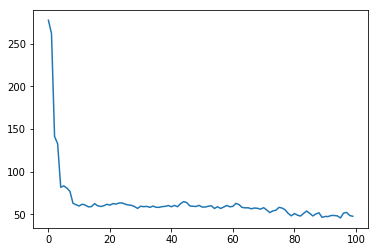

In [175]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

m (40, 10)


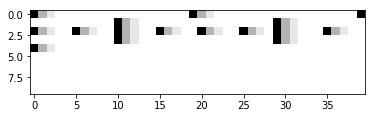

m (40, 10)


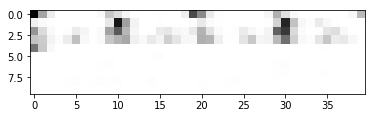

m (40, 10)


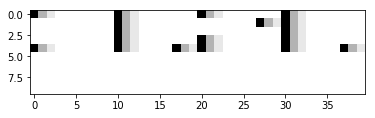

m (40, 10)


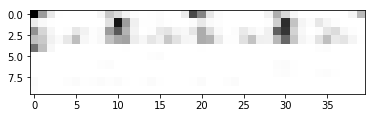

m (40, 10)


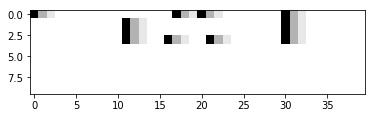

m (40, 10)


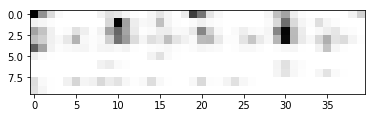

In [176]:
i = 0
j = 30
k = -1
x = vae.predict(x_train[:100])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])
plot.single(x_train[k, :50, :, 0])
plot.single(x[k, :50, :, 0])

In [177]:
x.shape

(81, 40, 10, 1)

m (30, 10)


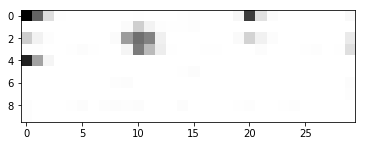

In [178]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 10)


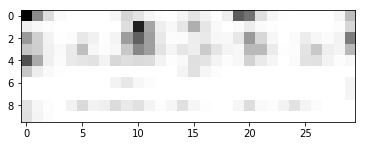

In [179]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Generator
A model to project inputs on the latent space

In [180]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [181]:
x_test.shape

(9, 40, 10, 1)

In [182]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(81, 2)

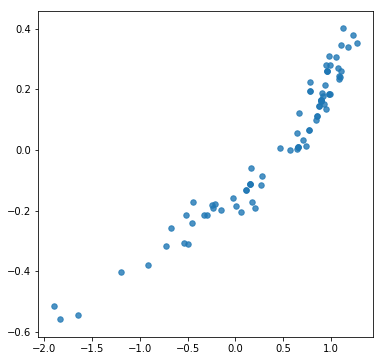

In [183]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.8, s=30) # c=y_test, 

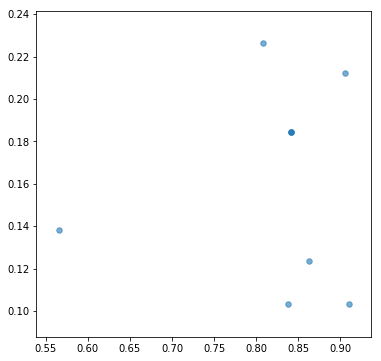

In [184]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.6, s=30) # , c=y_test
# plt.colorbar()

In [185]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [186]:
# x_decoded[0].reshape(150,3)

In [187]:
x_train.shape

(81, 40, 10, 1)

(2,) [0. 0.]


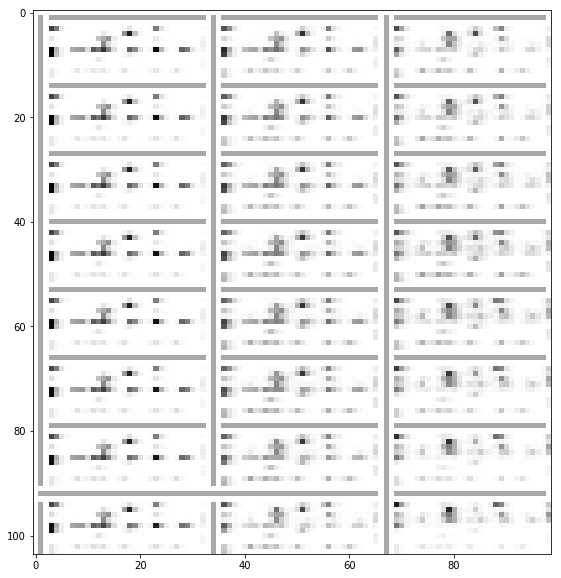

In [188]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

(2,) [0. 0.]


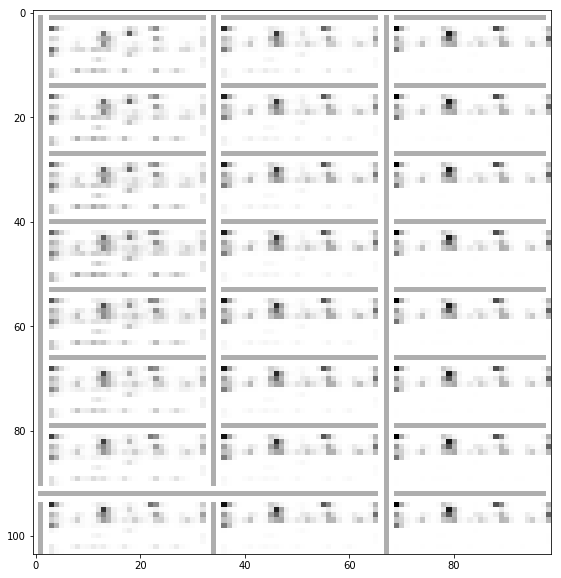

In [189]:
min_y2 = max_y
plot.latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)